In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm.keras import TqdmCallback
import warnings
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2  # Useremo ResNet50V2 come base più comune, ResNet18 non è direttamente disponibile in Keras Applications
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils import class_weight
warnings.filterwarnings('ignore')

2025-04-23 11:45:00.154168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745408700.350258      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745408700.403451      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [13]:
#File paths
image_folders = [
    '/kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer/brain_glioma',
    '/kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer/brain_menin',
    '/kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer/brain_tumor'
]
labels_mapping = {
    'brain_glioma': 'glioma',
    'brain_menin': 'menin',
    'brain_tumor': 'tumor'
}
class_names = list(labels_mapping.values())
num_classes = len(class_names)
image_size = (224, 224)
batch_size = 32
random_seed = 42
np.random.seed(random_seed)
##########################
images = []
labels = []
for folder in image_folders:
    label = labels_mapping[os.path.basename(folder)]
    for filename in os.listdir(folder):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(folder, filename)
            try:
                img = load_img(image_path, target_size=image_size)
                img_array = img_to_array(img)
                images.append(img_array)
                labels.append(label)
            except Exception as e:
                print(f"Error loading image: {image_path} - {e}")

In [14]:
# Convert to array numpy
images = np.array(images)
labels = np.array(labels)
# Encoding the labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded, num_classes=num_classes)
# Train-test split 80:20
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, stratify=labels_categorical, random_state=random_seed)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4844, 224, 224, 3), (1212, 224, 224, 3), (4844, 3), (1212, 3))

In [16]:
#Initializing class weights to tackle data imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels_encoded), y=labels_encoded)
class_weight_dict = dict(zip(range(num_classes), class_weights))
print("Class Weights:", class_weight_dict)

Class Weights: {0: 1.0073186959414504, 1: 1.0073186959414504, 2: 0.9856770833333334}


In [17]:
# Data Augmentation on the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
#Initialize a train and test generator
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True, seed=random_seed)
test_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size, shuffle=False, seed=random_seed)

In [19]:
# Load the base ResNet50V2 model (with pre-trained ImageNet weights)
base_model = ResNet50V2(
    weights='imagenet',        # Use weights pre-trained on ImageNet
    include_top=False,         # Exclude the final (fully connected) classification layer
    input_shape=(image_size[0], image_size[1], 3)  # Define input image shape (e.g., 128x128x3)
)

# Freeze all layers EXCEPT the last few
for layer in base_model.layers[:-10]:  # Keep only the last 10 layers trainable (you can adjust this number)
    layer.trainable = False


In [20]:
# Adding new layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)         # Reduces each feature map to a single number (reduces dimensionality)
x = BatchNormalization()(x)             # Normalizes activations, helps with training stability
x = Dense(512, activation='relu')(x)    # Fully connected layer with 512 units and ReLU activation
x = Dropout(0.5)(x)                     # Dropout layer to prevent overfitting (50% of the nodes are turned off randomly)
predictions = Dense(num_classes, activation='softmax')(x)  # Final classification layer with softmax for multi-class output

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
optimizer = Adam(learning_rate=1e-4)  # Adam optimizer with a learning rate of 0.0001
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy',   # Appropriate for multi-class classification with one-hot labels
              metrics=['accuracy'])              # Monitor model performance using accuracy
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv  

 Total params: 24,623,619 (93.93 MB)

 Trainable params: 4,470,787 (17.05 MB)

 Non-trainable params: 20,152,832 (76.88 MB)

In [21]:
# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',       # Watch the validation loss
    factor=0.2,               # Reduce learning rate by a factor of 0.2
    patience=5,               # Wait 5 epochs before reducing the learning rate
    min_lr=1e-6,              # Don't reduce learning rate below this value
    verbose=1                 # Print updates to console
)

# Stop training early if validation accuracy doesn't improve
early_stopping = EarlyStopping(
    monitor='val_accuracy',   # Monitor validation accuracy
    patience=10,              # Stop training after 10 epochs without improvement
    restore_best_weights=True, # Restore model weights from the best epoch
    verbose=1                 # Print early stopping messages
)
# Training the model
epochs = 30
history = model.fit(
    train_generator,
    steps_per_epoch=X_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=X_test.shape[0] // batch_size,
    callbacks=[TqdmCallback(verbose=1), reduce_lr, early_stopping],
    class_weight=class_weight_dict
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 68s 341ms/step - accuracy: 0.7278 - loss: 0.6821 - val_accuracy: 0.8944 - val_loss: 0.2788 - learning_rate: 1.0000e-04
Epoch 2/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9062 - loss: 0.3125 - val_accuracy: 0.8929 - val_loss: 0.2621 - learning_rate: 1.0000e-04
Epoch 3/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 46s 293ms/step - accuracy: 0.9040 - loss: 0.2720 - val_accuracy: 0.9485 - val_loss: 0.1342 - learning_rate: 1.0000e-04
Epoch 4/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9062 - loss: 0.2307 - val_accuracy: 0.9643 - val_loss: 0.0820 - learning_rate: 1.0000e-04
Epoch 5/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 46s 292ms/step - accuracy: 0.9245 - loss: 0.2097 - val_accuracy: 0.9595 - val_loss: 0.1085 - learning_rate: 1.0000e-04
Epoch 6/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7812 - loss: 0.4275 - val_accuracy: 1.0000 - val_loss: 0.0261 - learning_rate: 1.0000e-04
Epoch 7/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 46s 292ms/step

In [22]:
#Evaluating the model accuracy and loss
loss, accuracy = model.evaluate(test_generator)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9564 - loss: 0.1094

Test Loss: 0.1060
Test Accuracy: 0.9604


38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step


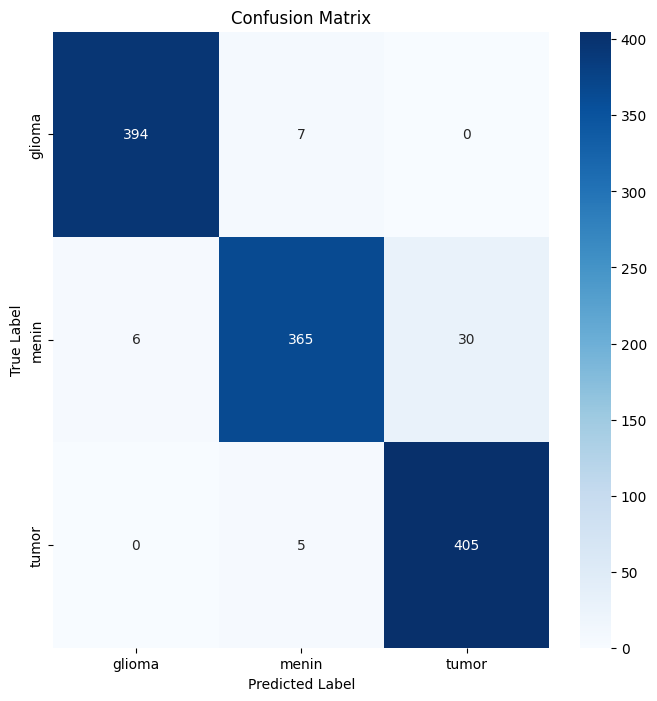

In [23]:
#Model confusion matrix using the predictions and test dataset
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)
class_labels = list(labels_mapping.values())
#Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [24]:
#Classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


Classification Report:
              precision    recall  f1-score   support

      glioma       0.98      0.98      0.98       401
       menin       0.97      0.91      0.94       401
       tumor       0.93      0.99      0.96       410

    accuracy                           0.96      1212
   macro avg       0.96      0.96      0.96      1212
weighted avg       0.96      0.96      0.96      1212

